In [0]:
#Connect google drive
from google.colab import drive
drive.mount('/content/gdrive')

import json
import zipfile
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import csv
import os
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import helper
from PIL import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Improve progress bar display
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm


# This will go away in the future.
# If this gives an error, you might be running TensorFlow 2 or above
# If so, the just comment out this line and run this cell again
#tf.enable_eager_execution() 

print("Tensorflow Version: ",tf.__version__)

#Download dataset from kaggle iFood 2019 competition
!wget https://food-x.s3.amazonaws.com/annot.tar
!tar -xf annot.tar
!rm -r annot.tar
!wget https://food-x.s3.amazonaws.com/train.tar
!tar -xf train.tar
!rm -r train.tar
!wget https://food-x.s3.amazonaws.com/val.tar
!tar -xf val.tar
!rm -r val.tar
!wget https://food-x.s3.amazonaws.com/test.tar  
!tar -xf test.tar
!rm -r test.tar

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Tensorflow Version:  1.13.1
--2019-05-31 12:43:40--  https://food-x.s3.amazonaws.com/annot.tar
Resolving food-x.s3.amazonaws.com (food-x.s3.amazonaws.com)... 52.216.130.211
Connecting to food-x.s3.amazonaws.com (food-x.s3.amazonaws.com)|52.216.130.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3123200 (3.0M) [application/x-tar]
Saving to: ‘annot.tar’

annot.tar           100%[===================>]   2.98M  13.1MB/s    in 0.2s    

2019-05-31 12:43:40 (13.1 MB/s) - ‘annot.tar’ saved [3123200/3123200]

--2019-05-31 12:43:44--  https://food-x.s3.amazonaws.com/train.tar
Resolving food-x.s3.amazonaws.com (food-x.s3.amazonaws.com)... 52.216.84.251
Connecting to food-x.s3.amazonaws.com (food-x.s3.amazonaws.com)|52.216.84.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2370519040 (2.2G) [application/x-tar

In [0]:
#############################################################
#                                                           #
# Hyperparameters setup and initialization of key variables #
#                                                           #
#############################################################
base_dir = '.'
train_dir = os.path.join(base_dir, 'train_set')
validation_dir = os.path.join(base_dir, 'val_set')
test_dir = os.path.join(base_dir, 'test_set')


# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "DenseNet201"

# Number of classes in the dataset
num_classes = 251

# Batch size for training (change depending on how much memory you have)
BATCH_SIZE = 128

# Learning rate
learning_rate = 0.001

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Set the image size (typically 224x224 for most of the models, however for inception it has to be 299x299)
image_size = 224

In [0]:
#Load label to text mapping as well as labels from files to python dictionaries 
#Label mapping (mapping from category label to category name) from text file to a dictionary
cat_to_name = {}
with open("class_list.txt") as f:
    for line in f:
       (key, val) = line.split()
       cat_to_name[int(key)] = val

train_labels = pd.read_csv(os.path.join(base_dir,'train_info.csv'), header=None)
train_labels.columns = ["img_name","label"] # add header
val_labels = pd.read_csv(os.path.join(base_dir,'val_info.csv'),header=None)
val_labels.columns = ["img_name","label"] # add header
test_labels = pd.read_csv(os.path.join(base_dir,'test_info.csv'), header=None)
test_labels.columns = ["img_name"] # add header
train_labels.iloc[:,1]= train_labels.iloc[:,1].astype(str) #convert label column to string data type expected by generator
val_labels.label = val_labels.label.astype(str) #convert label column to string data type expected by generator

In [0]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )
valid_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of batch_size using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(dataframe = train_labels,
                                                    directory = train_dir,
                                                    x_col = 'img_name',
                                                    y_col = 'label',
                                                    class_mode = 'categorical',
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (image_size, image_size)
                                                   )

# Flow validation images in batches of 20 using valid_datagen generator
validation_generator = valid_datagen.flow_from_dataframe(dataframe = val_labels,
                                                    directory = validation_dir,
                                                    x_col = 'img_name',
                                                    y_col = 'label',
                                                    class_mode = 'categorical',
                                                    batch_size = BATCH_SIZE,
                                                    target_size = (image_size, image_size)
                                                   )
# Flow test images in batches of 20 using valid_datagen generator
test_generator = test_datagen.flow_from_dataframe(dataframe = test_labels,
                                                   directory = test_dir,
                                                   x_col = 'img_name',
                                                   class_mode = None,
                                                   batch_size = BATCH_SIZE,
                                                   shuffle = False,
                                                   target_size = (image_size, image_size)
                                                  )

Found 118475 images belonging to 251 classes.
Found 11994 images belonging to 251 classes.
Found 28377 images.


In [0]:
##############################################
# Transfer learning                          #
#                                            #
##############################################

from tensorflow.keras import layers
from tensorflow.keras import Model

#Download file containing pretrained weights for the selected model
#!wget --no-check-certificate \
#    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

from tensorflow.keras.applications.densenet import DenseNet201 

#local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = DenseNet201(input_shape = (image_size, image_size, 3), 
                                include_top = True, 
                                weights = 'imagenet') #weights = None means that you have your own file with pretrained weights

#pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
#pre_trained_model.summary()

#Select last layer you want to use from the model
#In this case we select (i.e. mixed7) as the last layer in the model
last_layer = pre_trained_model.get_layer('avg_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 1920)


In [0]:
from tensorflow.keras.optimizers import SGD

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
#x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate (rate = 1 - keep_prob)
#x = layers.Dropout(rate=0.5)(x)                  
# Add additional 512 hidden layer with relu
#x = layers.Dense  (512, activation='relu')(x)
# Add final classification layer with relu
x = layers.Dense  (num_classes, activation='softmax')(x)

model = Model(pre_trained_model.input, x) 

#model.summary()


In [0]:
#below lines is only valid when you want to train on Colab TPUs
#export TPU_NAME=grpc://10.240.1.2:8470 #export environment variable on OS level before running Jupyter Notebook
#TPU_ADDRESS = 'grpc://10.240.1.2:8470' #This is for Google Cloud TPUs only
#tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR'] #This is for colab TPUs only

#tpu_model = tf.contrib.tpu.keras_to_tpu_model(
#    model,
#    strategy=tf.contrib.tpu.TPUDistributionStrategy(
#        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
#    )
#)


#change from "tpu_model.compile" to "model.compile" of you do not want to use TPUs
#tpu_model.compile(tf.train.MomentumOptimizer(learning_rate=0.001, momentum=0.9),
#                  loss = 'binary_crossentropy',
#                  metrics = ['acc'])

model.compile(optimizer = SGD(lr=learning_rate, momentum=0.9, decay=1e-6), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

# checkpoint
filepath="/content/gdrive/My Drive/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [0]:
num_train_examples = train_generator.samples

#Change from "tpu_model" to "model" if you do not want to use TPUs 
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            #steps_per_epoch = np.ceil(num_train_examples/BATCH_SIZE),
            epochs = num_epochs,
            #validation_steps = 50,
            verbose = 1,
            callbacks=callbacks_list
)



In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/gdrive/My Drive/DenseNet-201_model.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

In [0]:
# load json and create model
#from keras.models import model_from_json
#json_file = open("/content/gdrive/My Drive/DenseNet-201_model.json", 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights("/content/gdrive/My Drive/weights-improvement-11-0.67.hdf5")
print("Loaded model from disk")

OSError: ignored

In [0]:
#Predict the output
#You need to reset the test_generator before whenever you call the predict_generator. 
#This is important, if you forget to reset the test_generator you will get outputs in a weird order.
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()

pred=model.predict_generator(validation_generator,
                             use_multiprocessing = False,
                             steps=STEP_SIZE_TEST,
                             verbose=1)



In [0]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=validation_generator.filenames
results=pd.DataFrame({"img_name":filenames,
                      "label":predictions})
results
#val_labels

,img_name,label
0,val_010323.jpg,244
1,val_010324.jpg,61
2,val_010325.jpg,137
3,val_010326.jpg,218
4,val_010327.jpg,236
5,val_010328.jpg,144
6,val_010329.jpg,56
7,val_010330.jpg,244
8,val_010331.jpg,117
9,val_010332.jpg,15


In [0]:
def predict_one(model):
    font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 16,
        }
    image_batch, classes_batch = next(validation_generator)
    predicted_batch = model.predict(image_batch)
    for k in range(1):
      image = image_batch[k]
      pred = predicted_batch[k]
      print("pred: ",pred)
      the_pred = np.argmax(pred)
      print("the_pred: ",the_pred)
      the_pred=pred.argsort()[-3:][::-1]
      print("the_pred: ",the_pred)
      print(validation_generator.filenames[k])
      predicted = cat_to_name[the_pred[0]]
      print("predicted: ",predicted)
      val_pred = max(pred)
      print("val_pred: ",val_pred)
      the_class = np.argmax(classes_batch[k])
      print("classes_batch[k]: ",classes_batch[k])
      print("the_class: ",the_class)
      value = cat_to_name[np.argmax(classes_batch[k])]
      print("value: ",value)
      plt.figure(k)
      isTrue = (the_pred == the_class)
      plt.title((str(isTrue) + ' - class: ' + value + ' - ' + 'predicted: ' + predicted + '[' + str(val_pred) + ']'), fontdict=font)
      plt.imshow(image)
predict_one(model)

NameError: ignored

In [0]:
#For each element print indexes of numpy array elements containing top-3 numbers with the highest value (top-3 accuracy)
#validation_generator.reset()
for i in range(pred.shape[0]):
  print(validation_generator.filenames[i])
  print(pred[i].argsort()[-3:][::-1]) 
  print('[' + cat_to_name[pred[i].argsort()[-3:][::-1][0]] + ' ' + cat_to_name[pred[i].argsort()[-3:][::-1][1]] + ' ' + cat_to_name[pred[i].argsort()[-3:][::-1][2]] + ']')
  

val_010323.jpg
[188  98  73]
[cheesecake lasagna baklava]
val_010324.jpg
[ 64 221  34]
[fondue toad_in_the_hole scrambled_eggs]
val_010325.jpg
[124 136 156]
[boiled_egg frozen_yogurt donut]
val_010326.jpg
[133 107 185]
[fried_calamari crumpet chicken_quesadilla]
val_010327.jpg
[114  14 113]
[beef_carpaccio stuffed_cabbage french_onion_soup]
val_010328.jpg
[ 16 123  14]
[chow_mein fried_rice stuffed_cabbage]
val_010329.jpg
[122  81  37]
[pork_chop garlic_bread sushi]
val_010330.jpg
[103  55 109]
[sauerbraten terrine strawberry_shortcake]
val_010331.jpg
[ 63 112 141]
[pavlova croque_madame ceviche]
val_010332.jpg
[192 180 108]
[manicotti tagliatelle taco]
val_010333.jpg
[222 173 150]
[chicken_marengo baked_alaska bruschetta]
val_010334.jpg
[195 141  25]
[oyster ceviche ramen]
val_010335.jpg
[ 61 102  76]
[sauerkraut crab_cake edamame]
val_010336.jpg
[226  57  41]
[fish_stick gnocchi beef_stroganoff]
val_010337.jpg
[ 93 104 249]
[chicken_wing peking_duck buffalo_wing]
val_010338.jpg
[158 

KeyboardInterrupt: ignored

In [0]:
##############################################
# Submission of results to kaggle server     #
##############################################
os.environ["KAGGLE_USERNAME"] = "technic2017"
os.environ["KAGGLE_KEY"] = "db6bd82821e7ecd01f6f83effc3cc41b"
strings = list()
for i in range(pred.shape[0]):
  predictions[i]=pred[i].argsort()[-3:][::-1]
  strings.append(predictions[i][0].astype(str)+' '+predictions[i][1].astype(str)+' '+predictions[i][2].astype(str))
  
submission = pd.DataFrame()
submission['img_name'] = test_generator.filenames
submission['label'] = strings
submission.to_csv("submission.csv", index=False)


#!kaggle competitions submit -c ifood-2019-fgvc6 -f submission.csv -m "version 0.2"

100% 737k/737k [00:02<00:00, 258kB/s]
Successfully submitted to iFood - 2019 at FGVC6

In [0]:
def predict_one(model):
    image_batch, classes_batch = next(validation_generator)
    predicted_batch = model.predict(image_batch)
    for k in range(0,image_batch.shape[0]):
      image = image_batch[k]
      pred = predicted_batch[k]
      the_pred = np.argmax(pred)
      predicted = cat_to_name[the_pred]
      val_pred = max(pred)
      the_class = np.argmax(classes_batch[k])
      value = cat_to_name[np.argmax(classes_batch[k])]
      plt.figure(k)
      isTrue = (the_pred == the_class)
      plt.title(str(isTrue) + ' - class: ' + value + ' - ' + 'predicted: ' + predicted + '[' + str(val_pred) + ']')
      plt.imshow(image)

predict_one(model)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
the_pred = np.argmax(pred)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [0]:
#Predict based on test_generator
def predict_one(model):
    image_batch = next(test_generator)
    predicted_batch = model.predict(image_batch)
    for k in range(0,image_batch.shape[0]):
      image = image_batch[k]
      pred = predicted_batch[k]
      the_pred = np.argmax(pred)
      predicted = cat_to_name[the_pred]
      val_pred = max(pred)
#      the_class = np.argmax(classes_batch[k])
#      value = cat_to_name[np.argmax(classes_batch[k])]
      plt.figure(k)
#      isTrue = (the_pred == the_class)
      plt.title('predicted: ' + predicted + '[' + str(val_pred) + ']')
      plt.imshow(image)


predict_one(model)

Output hidden; open in https://colab.research.google.com to view.

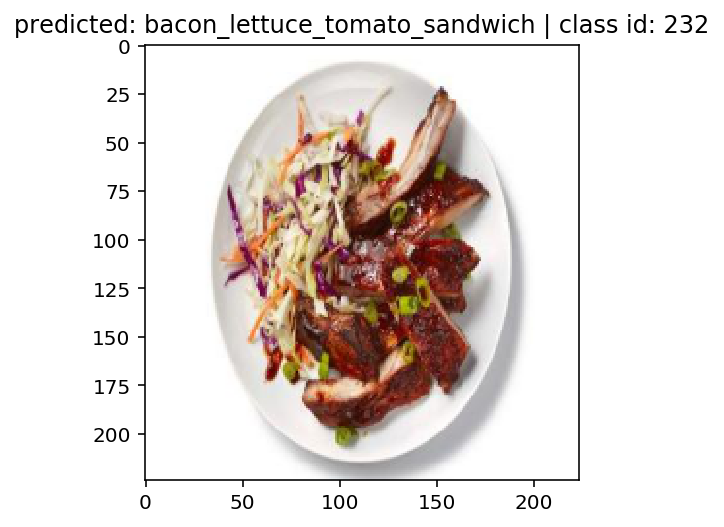

In [0]:
#Predict single image loaded from drive
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load(os.path.join(test_dir, 'test_000007.jpg'))
pred_image = model.predict(image)
the_pred = np.argmax(pred_image)
predicted = cat_to_name[the_pred]

plt.title('predicted: ' + predicted + ' | class id: ' + str(the_pred))
plt.imshow(image[0])

In [0]:
cat_to_name

{0: 'macaron',
 1: 'beignet',
 2: 'cruller',
 3: 'cockle_food',
 4: 'samosa',
 5: 'tiramisu',
 6: 'tostada',
 7: 'moussaka',
 8: 'dumpling',
 9: 'sashimi',
 10: 'knish',
 11: 'croquette',
 12: 'couscous',
 13: 'porridge',
 14: 'stuffed_cabbage',
 15: 'seaweed_salad',
 16: 'chow_mein',
 17: 'rigatoni',
 18: 'beef_tartare',
 19: 'cannoli',
 20: 'foie_gras',
 21: 'cupcake',
 22: 'osso_buco',
 23: 'pad_thai',
 24: 'poutine',
 25: 'ramen',
 26: 'pulled_pork_sandwich',
 27: 'bibimbap',
 28: 'chicken_kiev',
 29: 'apple_pie',
 30: 'risotto',
 31: 'fruitcake',
 32: 'chop_suey',
 33: 'haggis',
 34: 'scrambled_eggs',
 35: 'frittata',
 36: 'scampi',
 37: 'sushi',
 38: 'orzo',
 39: 'fritter',
 40: 'nacho',
 41: 'beef_stroganoff',
 42: 'beef_wellington',
 43: 'spring_roll',
 44: 'savarin',
 45: 'crayfish_food',
 46: 'souffle',
 47: 'adobo',
 48: 'streusel',
 49: 'deviled_egg',
 50: 'escargot',
 51: 'club_sandwich',
 52: 'carrot_cake',
 53: 'falafel',
 54: 'farfalle',
 55: 'terrine',
 56: 'poached_eg

In [0]:
pred.shape

(1, 251)

In [0]:
type(columns[0])

numpy.ndarray

In [0]:
predictions[0]

array([180,  17,  15])

In [0]:
columns.shape

(28377, 3)

In [0]:
np.max(pred[0])

0.40178967

In [0]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
  
np.sum(softmax(pred[3]))

1.0

In [0]:
!cat submission.csv

28378


TypeError: ignored

In [0]:
val_labels

,img_name,label
0,val_010323.jpg,247
1,val_010324.jpg,234
2,val_010325.jpg,222
3,val_010326.jpg,240
4,val_010327.jpg,218
5,val_010328.jpg,221
6,val_010329.jpg,243
7,val_010330.jpg,243
8,val_010331.jpg,222
9,val_010332.jpg,237
